In [1]:
import MeCab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
from tqdm.auto import tqdm
import seaborn as sns
warnings.filterwarnings(action='ignore')
mecab = MeCab.Tagger()

In [2]:
import pandas as pd
train_data = pd.read_csv('./steam.txt',header = 0, delimiter = '\t')

In [3]:
df=train_data[["label","document"]]
df.rename(columns={"label":"y_label","document":"review"},inplace=True)

In [4]:
df_text=df['review']
df_text=np.array(df_text)

In [5]:
from konlpy.tag import Mecab
mecab=Mecab(dicpath='C:/mecab/mecab-ko-dic')

## 명사만 뽑아오기

In [6]:
token_list=[]

for text in df['review']:
    token = mecab.pos(str(text))
    pos_list=[]
    for i in range(len(token)):
        if token[i][1] in ['NNG', 'NNP']:
            pos_list.append(token[i][0])
    token_list.append(pos_list)

In [7]:
result=pd.DataFrame(token_list)

In [8]:
df['noun']=token_list

In [9]:
df

,y_label,review,noun
0,0,노래가 너무 적음,[노래]
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다.","[황숙, 공장]"
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험, 판, 막노동, 사람, 장비]"
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,"[차악, 차악, 차악, 왕국]"
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,"[시간, 도전, 과제]"
...,...,...,...
99995,0,한글화해주면 10개산다,[한글]
99996,0,개쌉노잼 ㅋㅋ,[개]
99997,0,노잼이네요... 30분하고 지웠어요...,"[노, 잼]"
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,"[야생, 사랑, 사람, 여운, 이야기, 영어]"


## 명사가 없는 행 제거

In [10]:
list1=[]
for i in df.index:
    if df['noun'][i]==[]:
        pass
    else:
        list1.append(df.iloc[i,:])

In [11]:
df=pd.DataFrame(list1)
df

,y_label,review,noun
0,0,노래가 너무 적음,[노래]
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다.","[황숙, 공장]"
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험, 판, 막노동, 사람, 장비]"
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,"[차악, 차악, 차악, 왕국]"
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,"[시간, 도전, 과제]"
...,...,...,...
99995,0,한글화해주면 10개산다,[한글]
99996,0,개쌉노잼 ㅋㅋ,[개]
99997,0,노잼이네요... 30분하고 지웠어요...,"[노, 잼]"
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,"[야생, 사랑, 사람, 여운, 이야기, 영어]"


In [12]:
df.reset_index(inplace=True)

In [13]:
df['y_label'].value_counts()

0    47881
1    47679
Name: y_label, dtype: int64

## 통계적 트리밍

In [14]:
from collections import Counter

def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [15]:
wc = word_count(df['noun'])
wc

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
17,게임,34260,45580,1.0,0.077877,0.077877,0.358518
26,겜,8823,10105,2.0,0.017265,0.095142,0.092329
235,플레이,5992,6729,3.0,0.011497,0.106639,0.062704
27,때,5076,5517,4.0,0.009426,0.116065,0.053118
43,재미,4607,4857,5.0,0.008299,0.124364,0.048211
...,...,...,...,...,...,...,...
21589,민들레,1,1,21590.0,0.000002,0.999993,0.000010
21590,리하,1,1,21591.0,0.000002,0.999995,0.000010
21591,우양,1,1,21592.0,0.000002,0.999997,0.000010
21592,베인,1,1,21593.0,0.000002,0.999998,0.000010


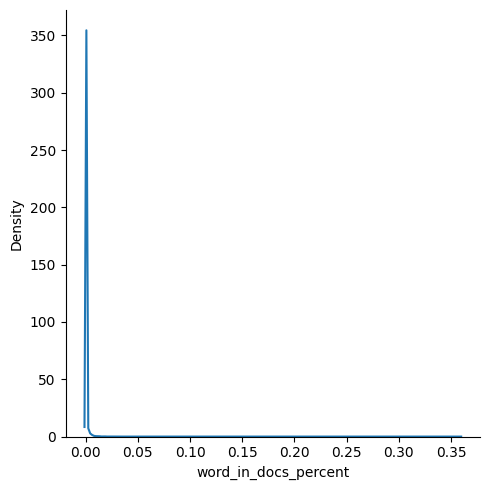

In [16]:
sns.displot(wc['word_in_docs_percent'], kind='kde');

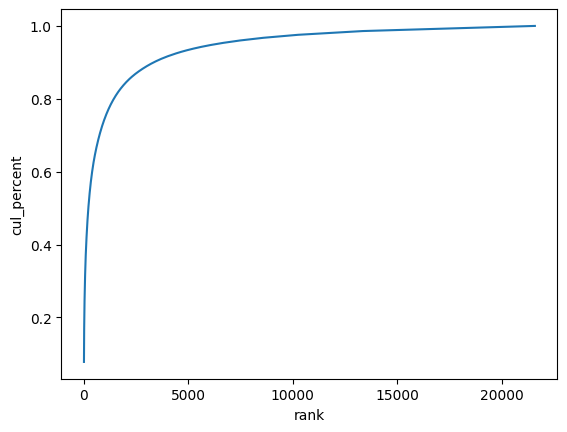

In [17]:
# 5000개 미만의 단어로 0.8 퍼센트를 차지한다.

import seaborn as sns

    # 누적분포그래프(CDF)
sns.lineplot(x='rank', y='cul_percent', data=wc);

In [18]:
wc[wc['rank'] <= 900]['cul_percent'].max()

0.7305235245171993

### 최다 빈도 단어는 리뷰 분석에 필요 없다고 판단됨

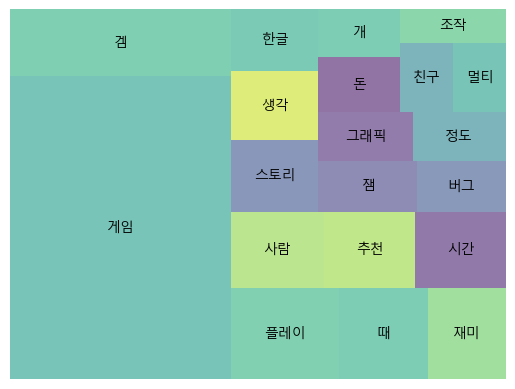

In [19]:
import matplotlib.pyplot as plt
import squarify
plt.rc('font', family='Malgun Gothic')
color=['viridis']

wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.6)
plt.axis('off')
plt.show()


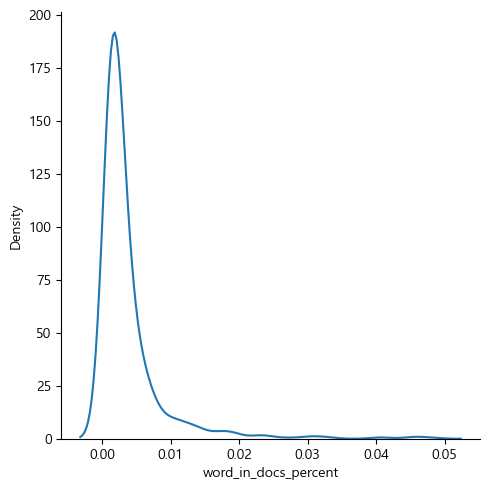

In [20]:
# 최소한 0.1% 이상 문서에 나타나는 단어들만 선택하고 5% 보다 작은 단어를 선택하여 게임이나 겜 등 리뷰 분석에 불필요한 단어 제거

wc = wc[wc['word_in_docs_percent'] >= 0.001]
wc = wc[wc['word_in_docs_percent'] <= 0.05]

sns.displot(wc['word_in_docs_percent'], kind='kde');

In [47]:
wc.drop(['percent','cul_percent'],axis=1)

,word,word_in_docs,count,rank,word_in_docs_percent
43,재미,4607,4857,5.0,0.048211
6,사람,4386,4842,6.0,0.045898
142,추천,4444,4724,7.0,0.046505
12,시간,4269,4714,8.0,0.044674
250,스토리,3930,4308,9.0,0.041126
...,...,...,...,...,...
2713,값어치,96,99,921.0,0.001005
2777,특정,97,99,922.0,0.001015
1547,커뮤니티,96,98,926.0,0.001005
908,환,96,97,929.0,0.001005


In [22]:
df['noun2'] = df['noun'].apply(lambda words: ' '.join([word for word in words if word in wc['word'].values]))

In [23]:
df

,index,y_label,review,noun,noun2
0,0,0,노래가 너무 적음,[노래],노래
1,1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다.","[황숙, 공장]",
2,2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,"[막노동, 체험, 판, 막노동, 사람, 장비]",체험 판 사람 장비
3,3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,"[차악, 차악, 차악, 왕국]",
4,4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,"[시간, 도전, 과제]",시간 도전 과제
...,...,...,...,...,...
95555,99995,0,한글화해주면 10개산다,[한글],한글
95556,99996,0,개쌉노잼 ㅋㅋ,[개],개
95557,99997,0,노잼이네요... 30분하고 지웠어요...,"[노, 잼]",노 잼
95558,99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,"[야생, 사랑, 사람, 여운, 이야기, 영어]",사랑 사람 이야기 영어


In [24]:
final=df[['noun2','y_label']]
final.columns=['text','label']

In [25]:
# 문장 띄어쓰기별로 리스트로 만들기 함수
def func2(x):
    import itertools
    texts = [x.split(' ')]
    texts = list(itertools.chain(*texts))
    return texts

In [26]:
df4=final
df4

,text,label
0,노래,0
1,,0
2,체험 판 사람 장비,1
3,,1
4,시간 도전 과제,1
...,...,...
95555,한글,0
95556,개,0
95557,노 잼,0
95558,사랑 사람 이야기 영어,1


In [27]:
m0=df4['label']==0
df0=df4[m0]
df0=df0.dropna()
df0=df0.reset_index(drop=True)

In [28]:
list0=[]
for i in range(len(df0)):
    list0.append(func2(df0['text'][i]))

In [29]:
df0['text_to_list']=list0

In [30]:
wc0 = word_count(df0['text_to_list'])
wc0.columns=['word','word_in_docs','count','rank','percent','cul_percent','word_in_docs_percent']

In [31]:
wc0_2=wc0.sort_values('word_in_docs_percent', ascending=False)
len(wc0)

903

In [32]:
wc0

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
1,,3121,3121,1.0,0.016372,0.016372,0.065182
55,사람,2235,2473,2.0,0.012973,0.029344,0.046678
3,버그,1976,2364,3.0,0.012401,0.041745,0.041269
58,돈,2169,2333,4.0,0.012238,0.053983,0.045300
102,재미,2171,2292,5.0,0.012023,0.066006,0.045342
...,...,...,...,...,...,...,...
839,한편,19,19,899.0,0.000100,0.999743,0.000397
888,흠,16,16,900.0,0.000084,0.999827,0.000334
902,굳,13,14,901.0,0.000073,0.999900,0.000272
687,굿,12,12,902.0,0.000063,0.999963,0.000251


## 1번라벨 많이 나오는 단어

In [33]:
m1=df4['label']==1
df1=df4[m1]
df1=df1.dropna()
df1=df1.reset_index(drop=True)

In [34]:
list1=[]
for i in range(len(df1)):
    list1.append(func2(df1['text'][i]))

In [35]:
df1['text_to_list']=list1

In [36]:
wc1 = word_count(df1['text_to_list'])
wc1.columns=['word','word_in_docs','count','rank','percent','cul_percent','word_in_docs_percent']

In [37]:
wc1
wc1_2=wc1.sort_values('word_in_docs_percent', ascending=False)
len(wc1)

903

In [38]:
w0_top50=wc0_2.head(100)

In [39]:
w1_top50=wc1_2.head(100)

In [40]:
w0_top50['only'] = w0_top50['word'].apply(lambda word: word if word not in w1_top50['word'].values else '')

In [41]:
w1_top50['only'] = w1_top50['word'].apply(lambda word: word if word not in w0_top50['word'].values else '')

In [42]:
w0_top50=w0_top50.reset_index()
w1_top50=w1_top50.reset_index()

In [43]:
list1=[]
list2=[]
for i in w0_top50.index:
    if w0_top50['only'][i]!='':
        list1.append(w0_top50.iloc[i,:])

for i in w1_top50.index:
    if w1_top50['only'][i]!='':
        list2.append(w1_top50.iloc[i,:])
        
only0=pd.DataFrame(list1)
only1=pd.DataFrame(list2)

In [44]:
wc_no_graph=only0
wc_yes_graph=only1

wc_no_graph_doc=wc_no_graph.copy()
wc_yes_graph_doc=wc_yes_graph.copy()

wc_no_graph['percent']=wc_no_graph['percent']*100
wc_yes_graph['percent']=wc_yes_graph['percent']*100

wc_no_graph_doc=wc_no_graph_doc.sort_values(by=['word_in_docs_percent'], ascending=False)
wc_yes_graph_doc=wc_yes_graph_doc.sort_values(by=['word_in_docs_percent'], ascending=False)



wc_no_graph_doc['word_in_docs_percent']=wc_no_graph_doc['word_in_docs_percent']*100
wc_yes_graph_doc['word_in_docs_percent']=wc_yes_graph_doc['word_in_docs_percent']*100

wc_yes_graph

,index,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent,only
16,116,최고,992,1039,19.0,0.586145,0.208631,0.020806,최고
24,42,타임,861,886,27.0,0.499831,0.251416,0.018058,타임
34,45,단점,709,738,39.0,0.416338,0.305619,0.014870,단점
43,50,액션,649,704,43.0,0.397157,0.321595,0.013612,액션
46,211,명작,590,666,46.0,0.375719,0.333200,0.012374,명작
48,23,요소,583,614,49.0,0.346384,0.343947,0.012228,요소
50,369,맛,568,602,52.0,0.339614,0.354169,0.011913,맛
51,41,밋,558,603,51.0,0.340178,0.350773,0.011703,밋
56,397,분위기,506,530,59.0,0.298996,0.376171,0.010613,분위기
57,109,작품,501,562,55.0,0.317048,0.363991,0.010508,작품


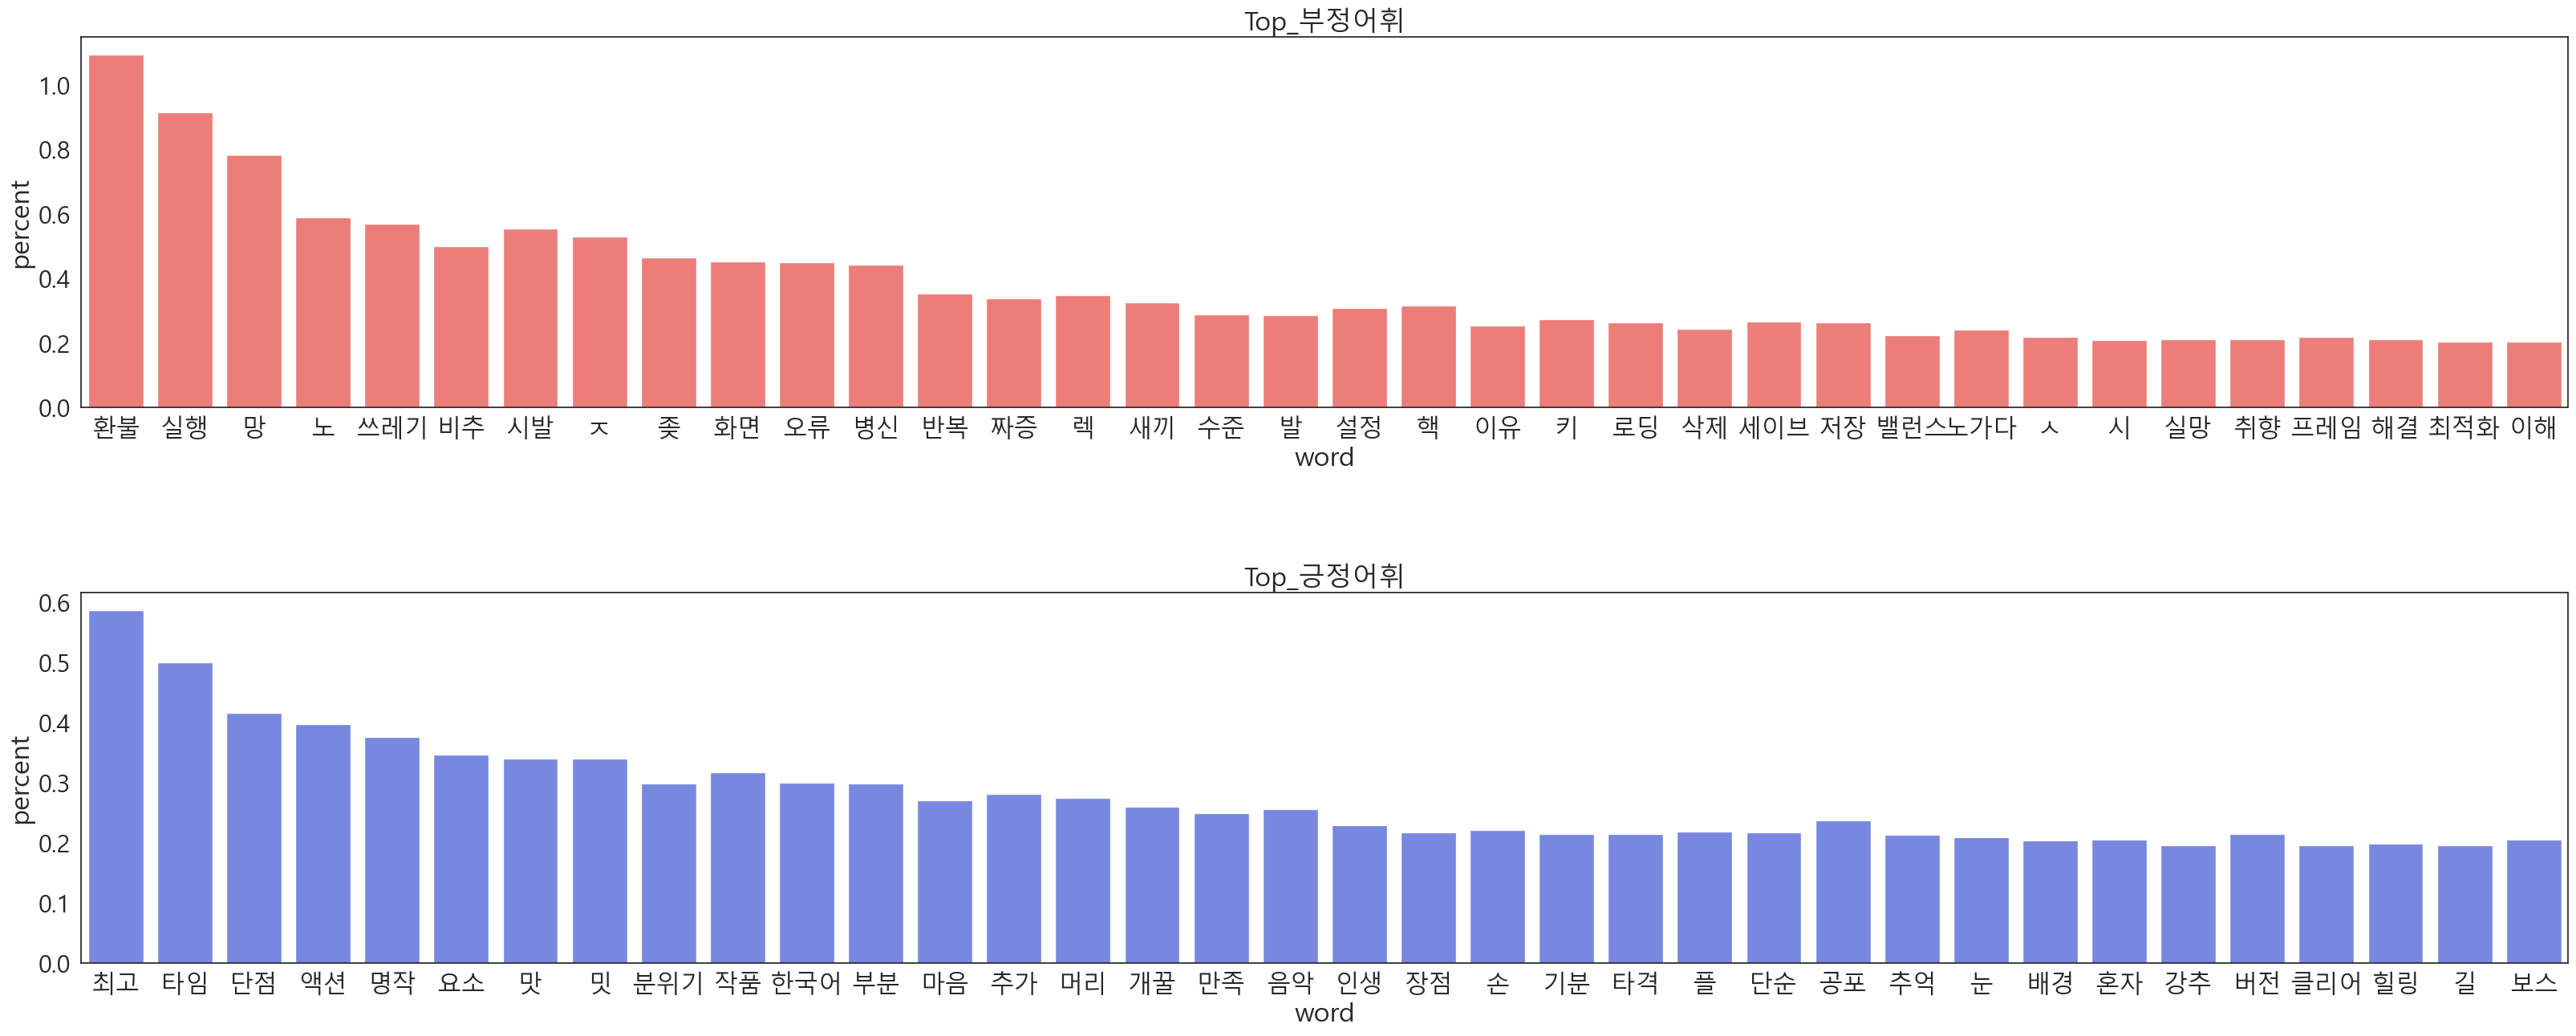

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 및 설정을 정의하세요 (wc_no_graph, wc_yes_graph, 폰트, 스타일 등)

sns.set(font="Malgun Gothic", rc={"axes.unicode_minus": False}, style="white", font_scale=2)

fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(40, 15)
colors0 = ["#FF6B66"]
colors1 = ["#677CF0"]

plot1 = sns.barplot(x=wc_no_graph["word"], y=wc_no_graph["percent"], ax=ax[0], palette=colors0)
plot1.set_title("Top_부정어휘")

plot2 = sns.barplot(x=wc_yes_graph["word"], y=wc_yes_graph["percent"], ax=ax[1], palette=colors1)
plot2.set_title("Top_긍정어휘")

# 서브플롯 간격 조정
plt.subplots_adjust(hspace=0.5)  # 필요한 만큼의 간격을 설정하세요

plt.show()
